In [75]:
import pandas as pd
import numpy as np
import scipy
import scanpy
import h5py
import os
import msgpack
import zlib
from matplotlib import pyplot
import anndata
import scvi
import zlib, msgpack, os
import json
import sqlite3
import h5py
import scipy
import pandas as pd
import anndata
import traceback
import h5py
import numpy as np
import bioalpha

plt.rcParams['pdf.use14corefonts'] = True

In [2]:
def run_scVI(adata, batchID='batch', n_dims=30):
    # subset to HVGs
    train_adata = adata[:, adata.var['highly_variable']].copy()
    scvi.model.SCVI.setup_anndata(train_adata, layer='raw', batch_key=batchID)
    
    arches_params = {
        "use_layer_norm": "both",
        "use_batch_norm": "none",
        "encode_covariates": True,
        "dropout_rate": 0.2,
        "n_layers": 2,
    }
    
    vae = scvi.model.SCVI(train_adata, n_latent=n_dims, gene_likelihood="nb", **arches_params)
    # vae.train() # 
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20)
    
    adata.obsm['X_scVI'] = vae.get_latent_representation()
    
    return {'adata': adata, 'vae': vae}


def post_dimred_processing(adata, dimred='X_pca', n_neighbors=10, run_clustering=True):
    # neighbourhood graph
    print("knn graph")
    scanpy.pp.neighbors(adata, use_rep=dimred, n_neighbors=n_neighbors)
    # UMAP
    print("UMAP")
    scanpy.tl.umap(adata)
    
    # Leiden clustering
    # if run_clustering:
    #     list_leiden_res = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     print("Leiden clustering")
    #     for leiden_res in list_leiden_res:
    #         print(leiden_res)
    #         scanpy.tl.leiden(adata, resolution=leiden_res, key_added='leiden_'+str(leiden_res).replace(".", "_"))
    
    # print("Diffusion map")
    # scanpy.tl.diffmap(adata)
    
    return adata

### Normalization

In [53]:
adata = scanpy.read_h5ad('combined_cosmx.h5ad')

/home/ub-sonvo-25d094476064960/.conda/envs/celltype_prediction/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [54]:
adata.obs['NANOSTRING_fovAnnotation'].unique()

['DKD_1-3', 'Ctrl_1', 'DKD_2-3', 'Ctrl_2']
Categories (4, object): ['Ctrl_1', 'Ctrl_2', 'DKD_1-3', 'DKD_2-3']

In [55]:
neg_adata = adata[
    :, adata.var_names.str.startswith('NegPrb')
]
neg_adata

View of AnnData object with n_obs × n_vars = 71333 × 19
    obs: 'BioTuring_Number of mRNA transcripts', 'BioTuring_Number of genes', 'BioTuring_Percentage of negative controls', 'BioTuring_Alexa-488_CD298_Membrane', 'BioTuring_Alexa-546_PanCK_Tumor', 'BioTuring_Alexa-594_CD45_Immune', 'BioTuring_Alexa-647_CD3_Immune', 'BioTuring_DAPI_DNA_Nuclei', 'NANOSTRING_fov', 'NANOSTRING_AspectRatio', 'NANOSTRING_Width', 'NANOSTRING_Height', 'NANOSTRING_Mean.CD45', 'NANOSTRING_Run_name', 'NANOSTRING_Slide_name', 'NANOSTRING_ISH.concentration', 'NANOSTRING_Commercial', 'NANOSTRING_Run_Slide_name', 'NANOSTRING_tissue', 'NANOSTRING_slide_ID_numeric', 'NANOSTRING_Run_Tissue_name', 'NANOSTRING_Panel', 'NANOSTRING_Diversity', 'NANOSTRING_totalcounts', 'NANOSTRING_log10totalcounts', 'NANOSTRING_background', 'NANOSTRING_remove_flagged_cells', 'NANOSTRING_nb_clus', 'NANOSTRING_cell_types_full', 'NANOSTRING_leiden_clus', 'NANOSTRING_Lees L Cluster 1', 'NANOSTRING_Lees L Cluster 1 truncated', 'NANOSTRING_Le

In [63]:
all_samples = neg_adata.obs['NANOSTRING_fovAnnotation'].unique()
all_samples_mean_negprb = []
for sp in all_samples:
    tmp_adata = neg_adata[
        neg_adata.obs['NANOSTRING_fovAnnotation'] == sp
    ]
    all_samples_mean_negprb.append(
        np.ravel(
            tmp_adata.layers['raw'].sum(axis=0)
        ) / tmp_adata.shape[0]
    )

In [61]:
from matplotlib import pyplot as plt

/tmp/ipykernel_1579003/571413979.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_samples_mean_negprb, labels=all_samples)


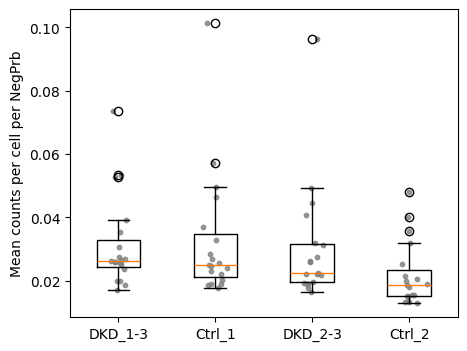

In [76]:
# Create box plot
plt.figure(figsize=(5, 4))
plt.boxplot(all_samples_mean_negprb, labels=all_samples)

for i, y in enumerate(all_samples_mean_negprb, start=1):
    x = np.random.normal(i, 0.05, size=len(y))  # jitter around box i
    plt.scatter(x, y, alpha=0.8, s=10, color='gray')

plt.ylabel('Mean counts per cell per NegPrb')
# plt.title('Boxplot of 4 Arrays')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('figs1_negprb.pdf')
plt.show()

In [77]:
adata = adata[
    :, 
    ~adata.var_names.str.startswith('NegPrb')
]

In [153]:
adata

View of AnnData object with n_obs × n_vars = 71333 × 989
    obs: 'BioTuring_Number of mRNA transcripts', 'BioTuring_Number of genes', 'BioTuring_Percentage of negative controls', 'BioTuring_Alexa-488_CD298_Membrane', 'BioTuring_Alexa-546_PanCK_Tumor', 'BioTuring_Alexa-594_CD45_Immune', 'BioTuring_Alexa-647_CD3_Immune', 'BioTuring_DAPI_DNA_Nuclei', 'NANOSTRING_fov', 'NANOSTRING_AspectRatio', 'NANOSTRING_Width', 'NANOSTRING_Height', 'NANOSTRING_Mean.CD45', 'NANOSTRING_Run_name', 'NANOSTRING_Slide_name', 'NANOSTRING_ISH.concentration', 'NANOSTRING_Commercial', 'NANOSTRING_Run_Slide_name', 'NANOSTRING_tissue', 'NANOSTRING_slide_ID_numeric', 'NANOSTRING_Run_Tissue_name', 'NANOSTRING_Panel', 'NANOSTRING_Diversity', 'NANOSTRING_totalcounts', 'NANOSTRING_log10totalcounts', 'NANOSTRING_background', 'NANOSTRING_remove_flagged_cells', 'NANOSTRING_nb_clus', 'NANOSTRING_cell_types_full', 'NANOSTRING_leiden_clus', 'NANOSTRING_Lees L Cluster 1', 'NANOSTRING_Lees L Cluster 1 truncated', 'NANOSTRING_L

In [ ]:
adata.write_h5ad(
    'MANUSCRIPT_DATA_2_SLIDES.h5ad'
)

### normalize with cell area

In [80]:
adata.X.data

array([1., 3., 1., ..., 1., 2., 1.])

In [81]:
adata.layers['raw'].data

array([1., 3., 1., ..., 1., 2., 1.])

In [82]:
adata.obs['NANOSTRING_fovAnnotation'].unique().tolist()

['DKD_1-3', 'Ctrl_1', 'DKD_2-3', 'Ctrl_2']

In [158]:
adata.X = adata.X / adata.obs['NANOSTRING_Area'].values.reshape(adata.shape[0], 1) * np.mean(adata.obs['NANOSTRING_Area'].values)

In [159]:
adata.X = adata.X.tocsr()

In [160]:
adata.X.data

array([1.75807824, 5.27423473, 1.75807824, ..., 2.57237101, 5.14474203,
       2.57237101])

In [161]:
adata.obs['NANOSTRING_Diversity'].unique()

array(['32', '79', '70', '103', '127', '31', '64', '56', '115', '131',
       '38', '138', '120', '116', '102', '40', '77', '81', '53', '119',
       '113', '60', '95', '136', '148', '45', '108', '267', '145', '150',
       '25', '186', '183', '147', '135', '253', '84', '140', '134', '66',
       '59', '76', '124', '155', '132', '55', '160', '122', '180', '78',
       '99', '48', '101', '149', '179', '89', '63', '193', '162', '137',
       '133', '82', '93', '110', '44', '90', '91', '114', '85', '34',
       '163', '264', '29', '94', '19', '125', '118', '156', '27', '24',
       '146', '172', '169', '72', '128', '49', '42', '96', '21', '22',
       '13', '86', '73', '75', '117', '109', '166', '187', '144', '104',
       '74', '83', '105', '112', '57', '107', '23', '98', '36', '18',
       '28', '61', '68', '50', '154', '87', '41', '121', '47', '142',
       '35', '26', '65', '62', '14', '37', '80', '39', '52', '69', '71',
       '43', '33', '54', '51', '20', '17', '67', '97', '46', '10

In [165]:
for i in adata.obs.columns:
    try:
        adata.obs[i] = adata.obs[i].values.astype('float')
    except:
        continue

In [166]:
adata.write_h5ad('normalized_adata.h5ad')

### Visualization

In [27]:
scanpy.pp.calculate_qc_metrics(
    adata, percent_top=None, log1p=False, inplace=True
)

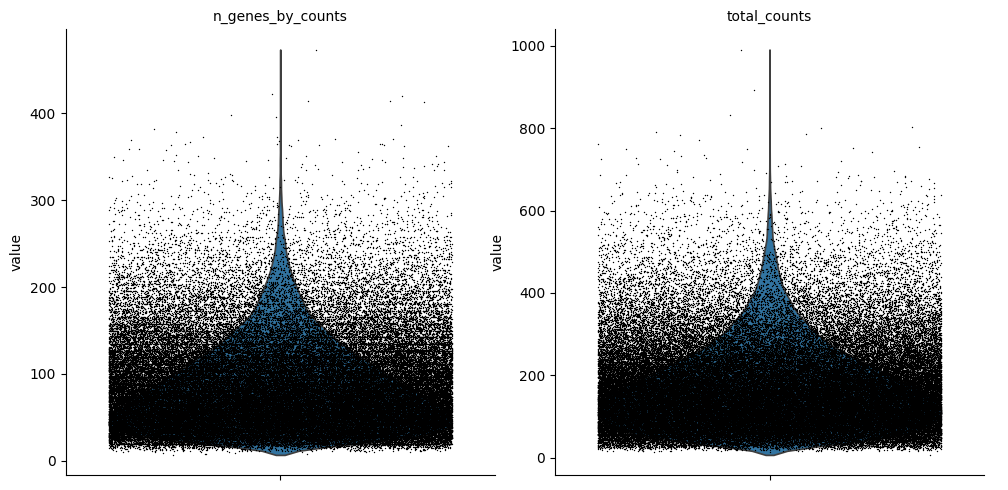

In [28]:
scanpy.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

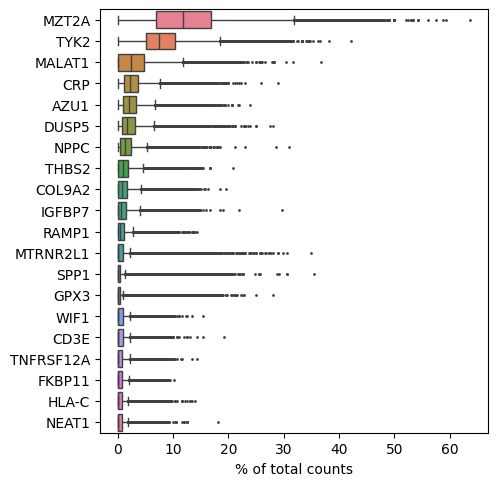

In [29]:
scanpy.pl.highest_expr_genes(adata, n_top=20)

### Batch correction with SCVI

**Note:** When comparing UMAP between 500 HVGs and 900 HVGs. 

- While 500 HVGs show seperated clusters of podocytes, 900 HVGs shows united cluster of podocytes
- 900 HVGs bring podocytes and endothelial cells closer rather than 500 HVGs

Conclusion: 900HVGs shows better performance

In [119]:
adata = scanpy.read_h5ad('normalized_adata.h5ad')

In [167]:
adata

AnnData object with n_obs × n_vars = 71333 × 989
    obs: 'BioTuring_Number of mRNA transcripts', 'BioTuring_Number of genes', 'BioTuring_Percentage of negative controls', 'BioTuring_Alexa-488_CD298_Membrane', 'BioTuring_Alexa-546_PanCK_Tumor', 'BioTuring_Alexa-594_CD45_Immune', 'BioTuring_Alexa-647_CD3_Immune', 'BioTuring_DAPI_DNA_Nuclei', 'NANOSTRING_fov', 'NANOSTRING_AspectRatio', 'NANOSTRING_Width', 'NANOSTRING_Height', 'NANOSTRING_Mean.CD45', 'NANOSTRING_Run_name', 'NANOSTRING_Slide_name', 'NANOSTRING_ISH.concentration', 'NANOSTRING_Commercial', 'NANOSTRING_Run_Slide_name', 'NANOSTRING_tissue', 'NANOSTRING_slide_ID_numeric', 'NANOSTRING_Run_Tissue_name', 'NANOSTRING_Panel', 'NANOSTRING_Diversity', 'NANOSTRING_totalcounts', 'NANOSTRING_log10totalcounts', 'NANOSTRING_background', 'NANOSTRING_remove_flagged_cells', 'NANOSTRING_nb_clus', 'NANOSTRING_cell_types_full', 'NANOSTRING_leiden_clus', 'NANOSTRING_Lees L Cluster 1', 'NANOSTRING_Lees L Cluster 1 truncated', 'NANOSTRING_Lees L Cl

In [171]:
scanpy.pp.log1p(adata)

In [172]:
adata.X.data

array([1.01453415, 1.83645152, 1.01453415, ..., 1.27322952, 1.81559676,
       1.27322952])

In [173]:
adata.obs['NANOSTRING_fovAnnotation'].unique()

['DKD_1-3', 'Ctrl_1', 'DKD_2-3', 'Ctrl_2']
Categories (4, object): ['Ctrl_1', 'Ctrl_2', 'DKD_1-3', 'DKD_2-3']

In [174]:
subset_adata = adata.copy()

In [175]:
scanpy.pp.highly_variable_genes(subset_adata, n_top_genes=700, batch_key='NANOSTRING_fovAnnotation')

In [ ]:
out_scVI = run_scVI(subset_adata, batchID="NANOSTRING_fovAnnotation")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 82/400:  20%|██████████████████████████                                                                                                     | 82/400 [00:22<01:29,  3.56it/s, v_num=1, train_loss_step=193, train_loss_epoch=191]

In [ ]:
subset_adata_scVI = out_scVI['adata'].copy()

In [ ]:
for i in list(subset_adata_scVI.obsm.keys()):
    if i != 'X_scVI':
        del subset_adata_scVI.obsm[i]

In [ ]:
subset_adata_scVI.write_h5ad('scvi_object.h5ad')

In [181]:
subset_adata_scVI

AnnData object with n_obs × n_vars = 71333 × 989
    obs: 'BioTuring_Number of mRNA transcripts', 'BioTuring_Number of genes', 'BioTuring_Percentage of negative controls', 'BioTuring_Alexa-488_CD298_Membrane', 'BioTuring_Alexa-546_PanCK_Tumor', 'BioTuring_Alexa-594_CD45_Immune', 'BioTuring_Alexa-647_CD3_Immune', 'BioTuring_DAPI_DNA_Nuclei', 'NANOSTRING_fov', 'NANOSTRING_AspectRatio', 'NANOSTRING_Width', 'NANOSTRING_Height', 'NANOSTRING_Mean.CD45', 'NANOSTRING_Run_name', 'NANOSTRING_Slide_name', 'NANOSTRING_ISH.concentration', 'NANOSTRING_Commercial', 'NANOSTRING_Run_Slide_name', 'NANOSTRING_tissue', 'NANOSTRING_slide_ID_numeric', 'NANOSTRING_Run_Tissue_name', 'NANOSTRING_Panel', 'NANOSTRING_Diversity', 'NANOSTRING_totalcounts', 'NANOSTRING_log10totalcounts', 'NANOSTRING_background', 'NANOSTRING_remove_flagged_cells', 'NANOSTRING_nb_clus', 'NANOSTRING_cell_types_full', 'NANOSTRING_leiden_clus', 'NANOSTRING_Lees L Cluster 1', 'NANOSTRING_Lees L Cluster 1 truncated', 'NANOSTRING_Lees L Cl

In [193]:
subset_adata_scVI = post_dimred_processing(subset_adata_scVI, dimred='X_scVI', n_neighbors=50)

knn graph
UMAP


In [184]:
batch_correction_df = pd.DataFrame(subset_adata_scVI.obsm['X_scVI'], index=subset_adata_scVI.obs_names)
batch_correction_df.to_csv('scvi_700_HVG.tsv', sep='\t')

In [194]:
umap_df = pd.DataFrame(subset_adata_scVI.obsm['X_umap'], index=subset_adata_scVI.obs_names)
umap_df.to_csv('scvi_700_HVG_UMAP_50neighbors.tsv', sep='\t')

### Visiualization 

In [186]:
scanpy.tl.leiden(subset_adata_scVI, resolution=0.5, key_added='BIOTURING_700HVG_leiden_on_scvi_0.5')

In [187]:
scanpy.tl.leiden(subset_adata_scVI, resolution=1.0, key_added='BIOTURING_700HVG_leiden_on_scvi_1.0')

In [188]:
scanpy.tl.leiden(subset_adata_scVI, resolution=1.5, key_added='BIOTURING_700HVG_leiden_on_scvi_1.5')

In [189]:
subset_adata_scVI.obs[
    ['BIOTURING_700HVG_leiden_on_scvi_0.5', 'BIOTURING_700HVG_leiden_on_scvi_1.0', 'BIOTURING_700HVG_leiden_on_scvi_1.5']
].to_csv('700HVG_leiden.tsv', sep='\t')

## spreading labels

In [83]:
adata

View of AnnData object with n_obs × n_vars = 71333 × 989
    obs: 'BioTuring_Number of mRNA transcripts', 'BioTuring_Number of genes', 'BioTuring_Percentage of negative controls', 'BioTuring_Alexa-488_CD298_Membrane', 'BioTuring_Alexa-546_PanCK_Tumor', 'BioTuring_Alexa-594_CD45_Immune', 'BioTuring_Alexa-647_CD3_Immune', 'BioTuring_DAPI_DNA_Nuclei', 'NANOSTRING_fov', 'NANOSTRING_AspectRatio', 'NANOSTRING_Width', 'NANOSTRING_Height', 'NANOSTRING_Mean.CD45', 'NANOSTRING_Run_name', 'NANOSTRING_Slide_name', 'NANOSTRING_ISH.concentration', 'NANOSTRING_Commercial', 'NANOSTRING_Run_Slide_name', 'NANOSTRING_tissue', 'NANOSTRING_slide_ID_numeric', 'NANOSTRING_Run_Tissue_name', 'NANOSTRING_Panel', 'NANOSTRING_Diversity', 'NANOSTRING_totalcounts', 'NANOSTRING_log10totalcounts', 'NANOSTRING_background', 'NANOSTRING_remove_flagged_cells', 'NANOSTRING_nb_clus', 'NANOSTRING_cell_types_full', 'NANOSTRING_leiden_clus', 'NANOSTRING_Lees L Cluster 1', 'NANOSTRING_Lees L Cluster 1 truncated', 'NANOSTRING_L

In [85]:
adata.obs['simplified_bioturing_celltypes'].unique().tolist()

['Unassigned',
 'Intercalated cell',
 'Endothelial cell',
 'Loop of Henle',
 'Myofibroblast',
 'Fibroblast',
 'Principal cell',
 'T cell',
 'Proximal tubule',
 'MNP_1',
 'MNP_2',
 'Distal Tubule',
 'B cell / Plasma cell',
 'Podocyte',
 'Kidney epithelial cell',
 'Mast cell']

In [56]:
ref_adata = adata[
    adata.obs['simplified_bioturing_celltypes'].values != 'Unassigned',
    :
]

In [57]:
query_adata = adata[
    adata.obs['simplified_bioturing_celltypes'].values == 'Unassigned',
    :
]

In [61]:
tmp_ref_adata = ref_adata.copy()

scvi.model.SCVI.setup_anndata(tmp_ref_adata, layer='raw', batch_key='NANOSTRING_fovAnnotation')

arches_params = {
    "use_layer_norm": "both",
    "use_batch_norm": "none",
    "encode_covariates": True,
    "dropout_rate": 0.2,
    "n_layers": 2,
}

vae = scvi.model.SCVI(tmp_ref_adata, n_latent=20, gene_likelihood="nb", **arches_params)
# vae.train() # 
vae.train(early_stopping=True,
    train_size=0.9,
    early_stopping_patience=45,
    max_epochs=400, 
    batch_size=1024, 
    limit_train_batches=20)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/sonvo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.
/data/sonvo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 400/400: 100%|███████████████████████████████| 400/400 [01:12<00:00,  6.08it/s, v_num=1, train_loss_step=281, train_loss_epoch=278]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████| 400/400 [01:12<00:00,  5.52it/s, v_num=1, train_loss_step=281, train_loss_epoch=278]


In [63]:
query_adata.obs['simplified_bioturing_celltypes'].unique()

array(['Unassigned'], dtype=object)

In [64]:
SCANVI_LABELS_KEY = "labels_scanvi"

ref_adata.obs[SCANVI_LABELS_KEY] = ref_adata.obs['simplified_bioturing_celltypes'].values

/tmp/ipykernel_3683030/4113317162.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ref_adata.obs[SCANVI_LABELS_KEY] = ref_adata.obs['manual_celltype'].values


In [65]:
scanvi_ref = scvi.model.SCANVI.from_scvi_model(
    vae,
    unlabeled_category="Unassigned",
    labels_key='simplified_bioturing_celltypes',
)

In [66]:
scanvi_ref.train(max_epochs=200, n_samples_per_label=500)

INFO     Training for 200 epochs.                                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/sonvo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|███████████████████████████████| 200/200 [32:29<00:00,  9.81s/it, v_num=1, train_loss_step=259, train_loss_epoch=274]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████| 200/200 [32:29<00:00,  9.75s/it, v_num=1, train_loss_step=259, train_loss_epoch=274]


In [67]:
tmp_query_adata = query_adata.copy()

In [68]:
del tmp_query_adata.obs['simplified_bioturing_celltypes']

In [69]:
scanvi_query = scvi.model.SCANVI.load_query_data(tmp_query_adata, scanvi_ref)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/data/sonvo/.local/lib/python3.10/site-packages/scvi/data/_manager.py:209: UserWarning: Missing labels key manual_celltype. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [70]:
scanvi_query.train(
    max_epochs=200,
    plan_kwargs={"weight_decay": 0.0},
    check_val_every_n_epoch=10,
)

INFO     Training for 200 epochs.                                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/sonvo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 11/200:   5%|█▋                               | 10/200 [00:13<04:14,  1.34s/it, v_num=1, train_loss_step=211, train_loss_epoch=203]

/data/sonvo/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|███████████████████████████████| 200/200 [04:34<00:00,  1.38s/it, v_num=1, train_loss_step=190, train_loss_epoch=213]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████| 200/200 [04:34<00:00,  1.37s/it, v_num=1, train_loss_step=190, train_loss_epoch=213]


In [71]:
query_adata.obs['predicted_celltype'] = scanvi_query.predict()

/tmp/ipykernel_3683030/1070132457.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query_adata.obs['predicted_celltype'] = scanvi_query.predict()
